# DICOM IMAGE

In [1]:
# INSTALL 
!pip install pydicom
!pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 13.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# %reload_ext signature
# %matplotlib inline
import skimage
import numpy as np
import pydicom as dicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
init_notebook_mode(connected=True) 
import pydicom.uid
import pandas as pd
import cv2
from PIL import Image
from matplotlib.path import Path

In [3]:
# DATA PATH
data_path = '/content/DICOM/'

In [8]:
# LOAD DATA AND BASIC INFORMATION

# filter slices
slice_name = []
for s in os.listdir(data_path):
  slices = dicom.read_file(data_path + s,force=True)
  if slices.SliceLocation == slices.ImagePositionPatient[-1]:
    slice_name.append(s)


# DICOM header INFORMATION
patient = [pydicom.dcmread(data_path + s) for s in slice_name]
print(patient[0]) 

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 206
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.6279.6001.211534356284883514840008377231
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002, 0013) Implementation Version Name         SH: '0.5'
(0002, 0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.6279.6001.21153

In [11]:
# PIXEL SPACING
pxy = patient[0].PixelSpacing
print(f"Pixel Spacing (row, col): ({pxy[0]}, {pxy[1]})")

Pixel Spacing (row, col): (0.703125, 0.703125)


In [19]:
#LOAD IMAGES
def get_pixels_hu(path):
    scans = [dicom.read_file(data_path+path,force=True)]
    image = np.stack([s.pixel_array for s in scans])
    image = image.astype(np.int16)
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)    
    return np.array(image, dtype=np.int16)

images = []
for p in slice_name:
  images.append(get_pixels_hu(p))

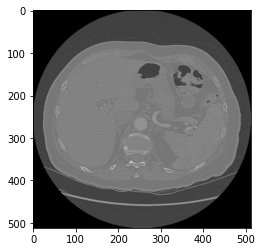

In [21]:
plt.imshow(images[0][0],cmap='gray') 

# RESAMPLE

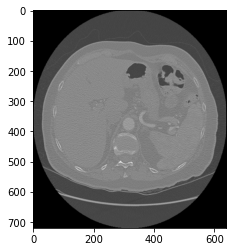

In [25]:
# CHANGE IN-PLANE RESOLUTION ---> RESAMPLE

def resample(img,i):
  spacing = map(float, [patient[i].PixelSpacing[0], patient[0].PixelSpacing[1], patient[i].SliceThickness])
  spacing = np.array(list(spacing))

  new_spacing = np.array([0.5,0.5,1])

  re_x = float(spacing[0] / new_spacing[0])
  re_y = float(spacing[1] / new_spacing[1])
  re_z = float(spacing[2] / new_spacing[2])

  sx = spacing[0] / re_x
  sy = spacing[1] / re_y
  sz = spacing[2] / re_y
  image = scipy.ndimage.interpolation.zoom(img, (re_x, re_y, re_z), order=1)
  return (image, (sx, sy, sz))

# test
re_imgs, re_spacing = resample(images[0], 0)
plt.imshow(re_imgs[0],cmap='gray') 